In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [13]:
# Replace 'Mic_data.csv' with your actual filename if different
df = pd.read_csv('mic_data.csv')
df = df.dropna()  # Remove any NaN rows
t = df['timestamp'].values
x = df['mic_value'].values

In [14]:
# Estimate sampling frequency from timestamps (assumes uniform sampling)
dt = np.mean(np.diff(t))
fs = 1.0 / dt
print(f'Sampling frequency: {fs:.2f} Hz')

Sampling frequency: 1.00 Hz


/tmp/ipykernel_19143/3560731169.py:5: UserWarning: nperseg=101 is greater than signal length max(len(x), len(y)) = 58, using nperseg = 58
  f, Pxx = welch(x, fs=fs, nperseg=101)


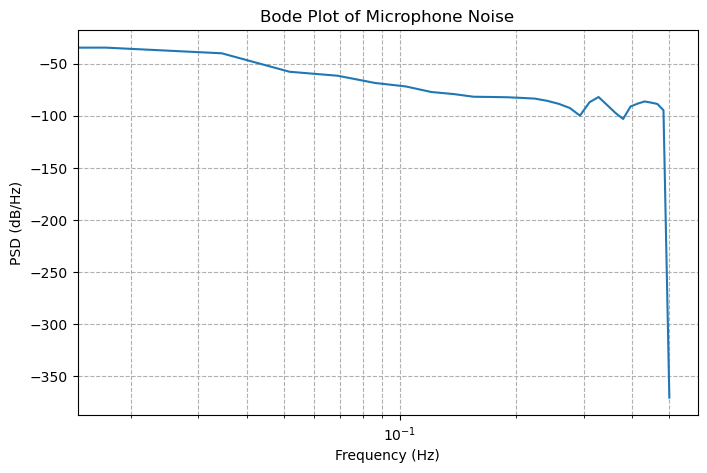

In [15]:
# Remove DC offset
x = x - np.mean(x)

# Compute PSD using Welch's method
f, Pxx = welch(x, fs=fs, nperseg=101)

# Plot on log-log scale
plt.figure(figsize=(8,5))
plt.semilogx(f, 10 * np.log10(Pxx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.title('Bode Plot of Microphone Noise')
plt.grid(True, which='both', ls='--')
plt.show()